# Import Libraries & Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
# Loading datasets
transactions = pd.read_csv('transactions.csv')
returns = pd.read_csv('returns.csv')

In [3]:
transactions.head()
returns.head()

,transaction_id,return_date,return_reason,product_condition,refund_amount
0,2,2023-06-12,Defective,New,25.45
1,6,2023-03-09,Changed Mind,Damaged,41.20
2,9,2023-06-09,Not as Described,Used,119.75
3,15,2023-02-02,Not as Described,New,182.00
4,26,2023-02-27,Defective,New,49.93


<ipython-input-4-b1576e13a304>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(returns, x='refund_amount', y='product_condition', inner='stick', palette='Dark2')


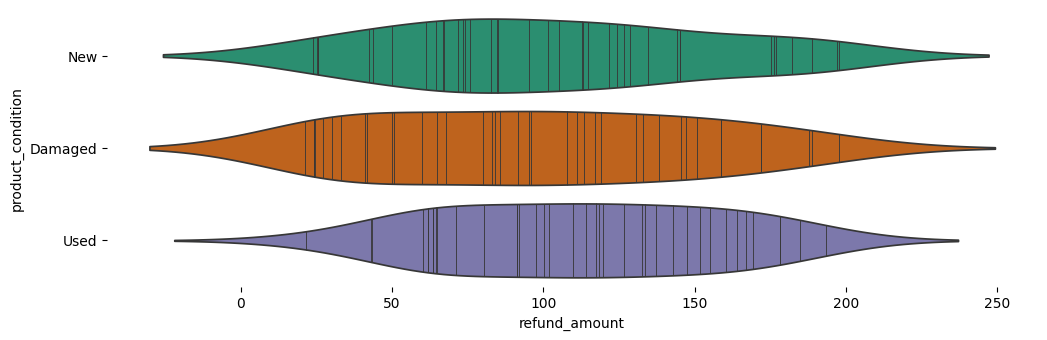

In [4]:
# @title product_condition vs refund_amount

figsize = (12, 1.2 * len(returns['product_condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(returns, x='refund_amount', y='product_condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

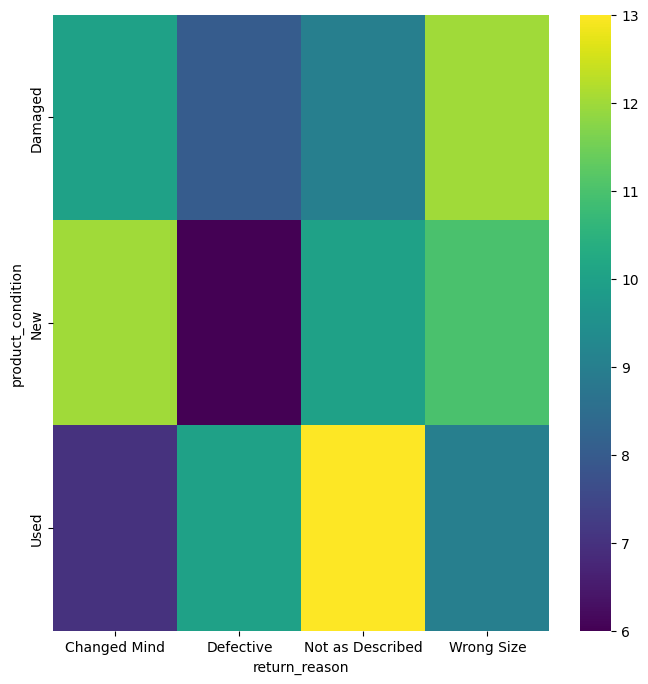

In [5]:
# @title return_reason vs product_condition

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_condition'].value_counts()
    for x_label, grp in returns.groupby('return_reason')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('return_reason')
_ = plt.ylabel('product_condition')

In [6]:
# Let's calculate total refund amount for each return reason
reason_refund = returns.groupby('return_reason')['refund_amount'].sum()


reason_refund

,refund_amount
return_reason,
Changed Mind,3099.02
Defective,2600.34
Not as Described,3358.16
Wrong Size,3196.76


# Data Cleaning

In [7]:
# Converting date columns to datetime format with type enforcement
transactions['order_date'] = pd.to_datetime(transactions['order_date'], errors='coerce')
transactions['delivery_date'] = pd.to_datetime(transactions['delivery_date'], errors='coerce')
returns['return_date'] = pd.to_datetime(returns['return_date'], errors='coerce')

In [8]:
# Fill missing values in transactions dataset
transactions.fillna({'price': 0, 'category': 'Unknown'}, inplace=True)

In [9]:
# Merging datasets on transaction_id
if 'transaction_id' in transactions.columns and 'transaction_id' in returns.columns:
    merged_data = pd.merge(transactions, returns, on='transaction_id', how='left')
else:
    raise KeyError("transaction_id column missing in one of the datasets")

In [10]:
# Calculate the time between purchase & return
merged_data['time_to_return'] = (merged_data['return_date'] - merged_data['delivery_date']).dt.days

# Added derived columns for analysis
merged_data['is_returned'] = merged_data['return_date'].notna()
merged_data['price_band'] = pd.cut(merged_data['price'], bins=[0, 50, 100, 200, 500, np.inf], labels=['Low', 'Medium', 'High', 'Very High', 'Luxury'])

# Exploratory Data Analysis

In [11]:
# statistics for returns by product category
returns_by_category = merged_data.groupby('category').agg(
    return_count=('transaction_id', 'count'),
    avg_price=('price', 'mean'),
    return_rate=('is_returned', 'mean')
).sort_values(by='return_count', ascending=False)

In [12]:
# Distribution of return reasons
return_reasons_distribution = merged_data['return_reason'].value_counts(normalize=True)

# Avg time to return with median
avg_time_to_return = merged_data['time_to_return'].mean()
median_time_to_return = merged_data['time_to_return'].median()
print(f"Average time to return: {avg_time_to_return:.2f} days")
print(f"Median time to return: {median_time_to_return:.2f} days")

Average time to return: 5.07 days
Median time to return: 5.00 days


# Visualizations

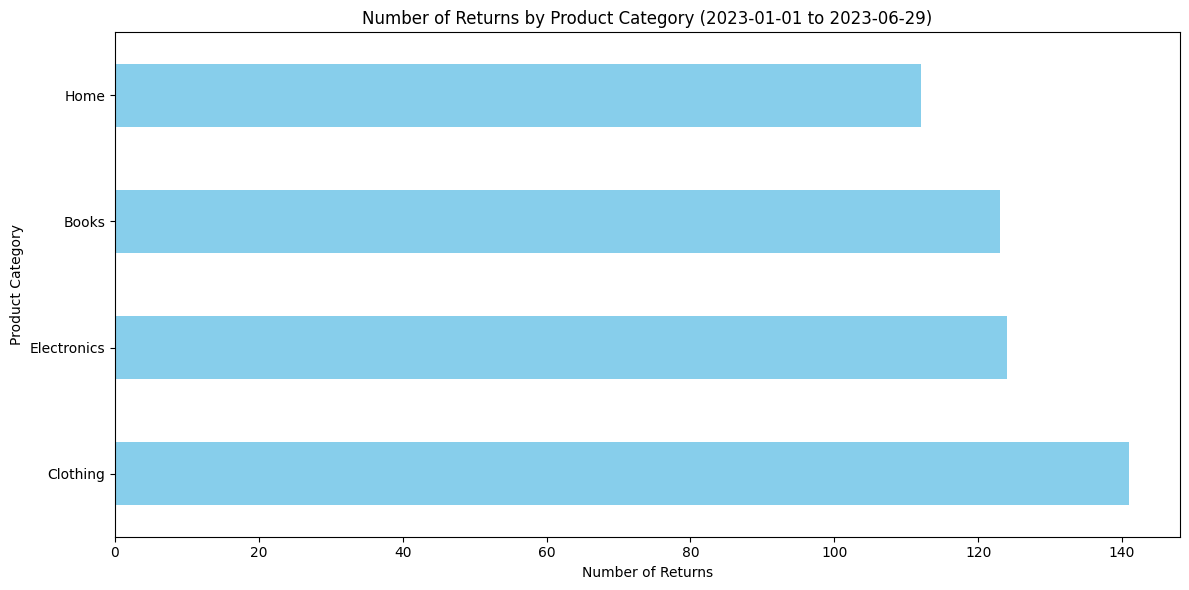

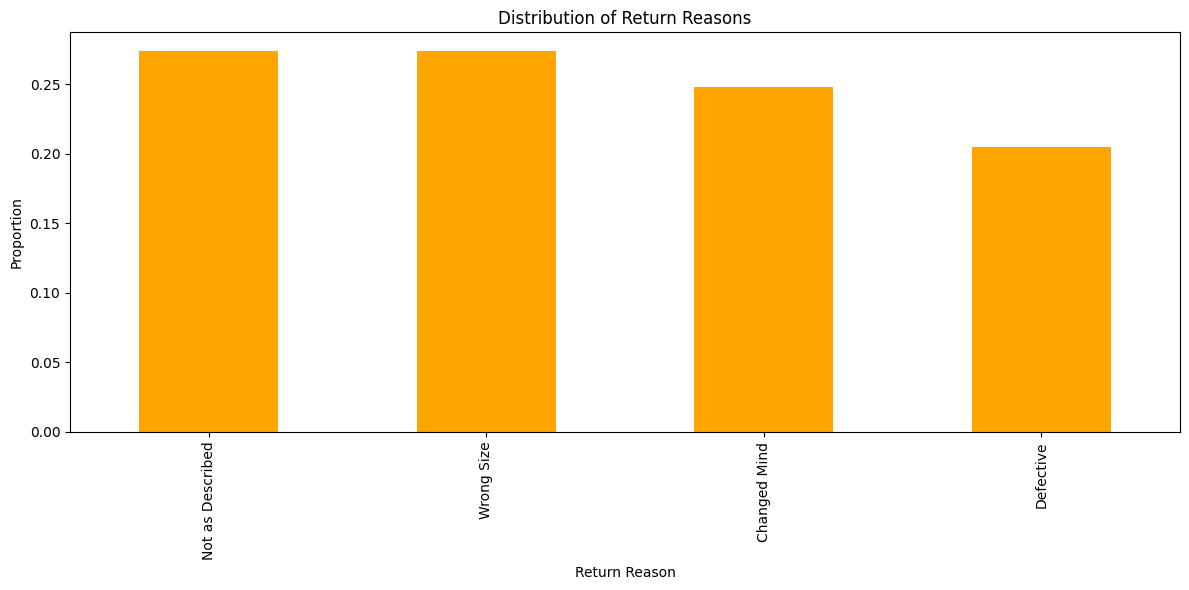

In [13]:
plt.figure(figsize=(12, 6))
returns_by_category['return_count'].plot(kind='barh', color='skyblue')
plt.title(f"Number of Returns by Product Category ({merged_data['order_date'].min().date()} to {merged_data['order_date'].max().date()})")
plt.xlabel('Number of Returns')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
return_reasons_distribution.plot(kind='bar', color='orange')
plt.title('Distribution of Return Reasons')
plt.xlabel('Return Reason')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

# Anomaly Detection

In [14]:
# High return rates by product
return_rate = merged_data.groupby('product_id').agg(
    transaction_count=('transaction_id', 'count'),
    return_count=('return_date', 'count')
)
return_rate['return_rate'] = return_rate['return_count'] / return_rate['transaction_count']
outlier_products = return_rate[return_rate['return_rate'] > return_rate['return_rate'].mean() + 2 * return_rate['return_rate'].std()]

In [15]:
# Abnormal return behavior by customers
customer_returns = merged_data.groupby('customer_id')['return_date'].count()
z_scores = zscore(customer_returns)
abnormal_customers = customer_returns[np.abs(z_scores) > 3]

In [16]:
# pivot table for return insights
pivot_table = pd.pivot_table(
    merged_data,
    values='is_returned',
    index='category',
    columns='price_band',
    aggfunc='mean',
    fill_value=0
)

<ipython-input-16-3422fb10c62c>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(


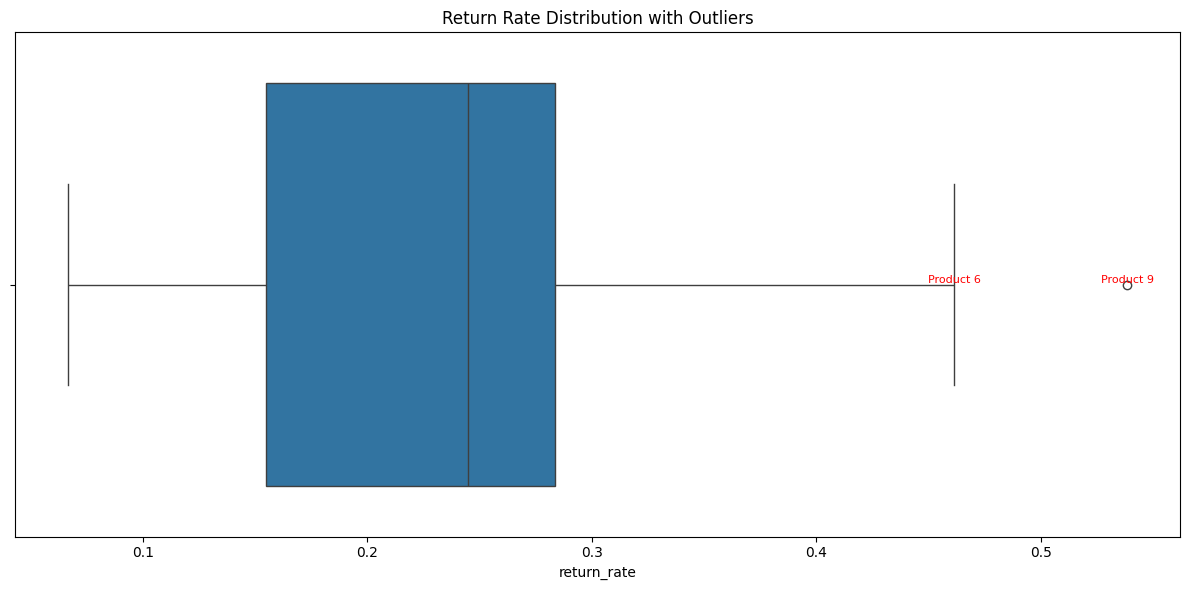

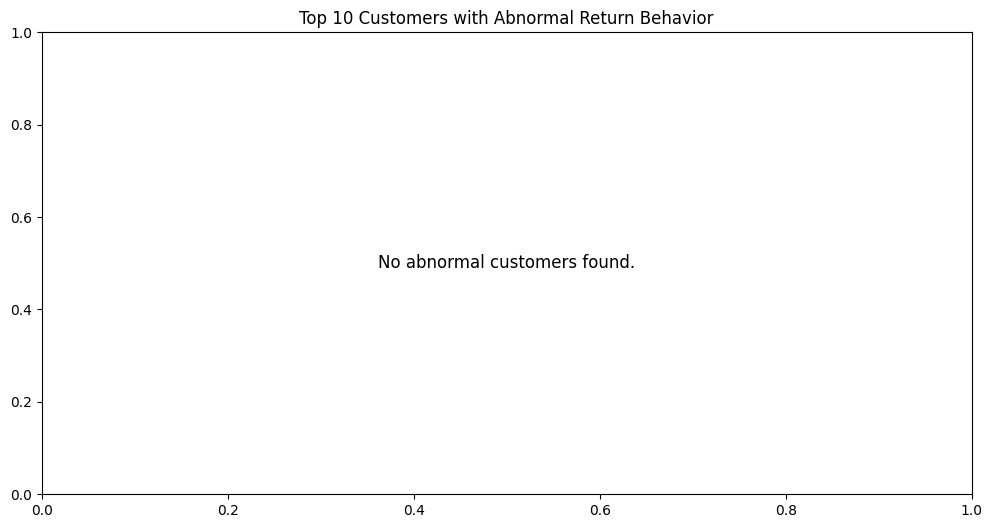

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=return_rate['return_rate'])
outliers = return_rate[return_rate['return_rate'] > return_rate['return_rate'].mean() + 2 * return_rate['return_rate'].std()]
for idx, value in outliers.iterrows():
    plt.text(value['return_rate'], 0, f"Product {idx}", horizontalalignment='center', verticalalignment='bottom', fontsize=8, color='red')
plt.title('Return Rate Distribution with Outliers')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Conditional Plotting
# Checking if abnormal_customers is empty before plot
if not abnormal_customers.empty:
    abnormal_customers.sort_values(ascending=False).head(10).plot(kind='bar', color='red')
    plt.title('Top 10 Customers with Abnormal Return Behavior')
    plt.xlabel('Customer ID')
    plt.ylabel('Number of Returns')
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, "No abnormal customers found.", horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.title('Top 10 Customers with Abnormal Return Behavior')

plt.show()

# Results

In [18]:
print("Summary:")
print(f"Average time to return: {avg_time_to_return:.2f} days")
print(f"Median time to return: {median_time_to_return:.2f} days")
print(f"Number of products with high return rates: {len(outlier_products)}")
print(f"Number of customers with abnormal return behavior: {len(abnormal_customers)}")
print("\nPivot Table of Return Rates by Category and Price Band:")
print(pivot_table)

Summary:
Average time to return: 5.07 days
Median time to return: 5.00 days
Number of products with high return rates: 2
Number of customers with abnormal return behavior: 0

Pivot Table of Return Rates by Category and Price Band:
price_band        Low    Medium      High
category                                 
Books        0.045455  0.171429  0.212121
Clothing     0.173913  0.161290  0.195402
Electronics  0.240000  0.384615  0.342466
Home         0.375000  0.323529  0.193548


In [19]:
# Merging outlier_products with merged_data to get category info
outlier_products_with_category = pd.merge(outlier_products, merged_data[['product_id', 'category']], on='product_id', how='left')

# selecting relevant columns to show
outlier_products_with_category = outlier_products_with_category[['product_id', 'category', 'return_rate']]

# show outlier products with category info
print("Products with High Return Rates (with Category):")
display(outlier_products_with_category)

Products with High Return Rates (with Category):


,product_id,category,return_rate
0,6,Clothing,0.461538
1,6,Electronics,0.461538
2,6,Home,0.461538
3,6,Books,0.461538
4,6,Home,0.461538
5,6,Books,0.461538
6,6,Electronics,0.461538
7,6,Books,0.461538
8,6,Electronics,0.461538
9,6,Clothing,0.461538


In [20]:
# Rechecking the abnormal return behavior by customers
customer_returns = merged_data.groupby('customer_id')['return_date'].count()
z_scores = zscore(customer_returns)
abnormal_customers = customer_returns[np.abs(z_scores) > 3]

# Display abnormal customers
print("\nCustomers with Abnormal Return Behavior:")
display(abnormal_customers.to_frame())  # Convert to DataFrame for display


Customers with Abnormal Return Behavior:


,return_date
customer_id,
